In [ ]:
#default_exp byol

# BYOL

> [Bootstrap Your Own Latent A New Approach to Self-Supervised Learning](https://arxiv.org/pdf/2006.07733.pdf)

In [ ]:
#export
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *

## Data Augmentation

We can use batch data augmentation utilities form `self_supervised.augmentations` module.

In [ ]:
#hide
img = PILImage(PILImage.create(TEST_IMAGE).resize((600,400)))
t = Pipeline([ToTensor(), IntToFloatTensor(), Resize(256)])(img)
type(img), type(t)

(fastai.vision.core.PILImage, fastai.torch_core.TensorImage)

SimCLR augmentations side by side with the original image

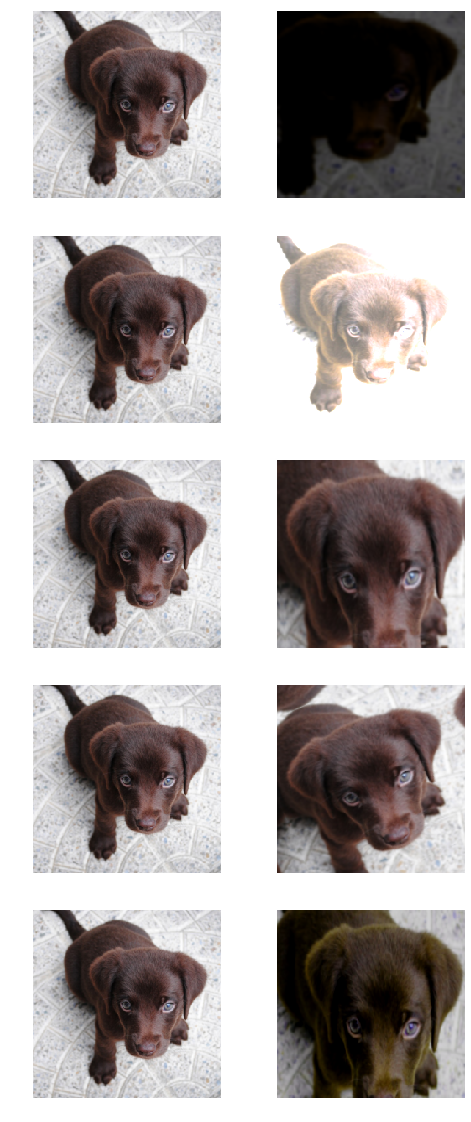

In [ ]:
aug = get_batch_augs(224, cuda=False)
n = 5
fig,ax = plt.subplots(n,2,figsize=(8,n*4))
for i in range(n):
    show_image(t,ax=ax[i][0])
    show_image(aug.decode(aug(t)).clamp(0,1)[0], ax=ax[i][1])

## Architecture

![](images/byol.png)

For encoder any PyTorch model which takes an image input and outputs embeddings/representations can be used. You can also use utilities to create encoder from the models defined in `fastai` or `timm` using the following functions: `create_fastai_encoder` and `create_timm_encoder`. Fastai expects a function such as `xresnet18` as first argument whereas timm expects a string like `"tf_efficientnet_b0_ns"`.

In [ ]:
timm_encoder = create_timm_encoder("tf_efficientnet_b0_ns", n_in=3, pretrained=False)

In [ ]:
L(timm_encoder.named_children())[-4:].itemgot(1)

(#4) [BatchNorm2d(1280, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),SiLU(inplace=True),SelectAdaptivePool2d (pool_type=catavgmax, flatten=True),Identity()]

In [ ]:
fastai_encoder = create_fastai_encoder(xresnet18, n_in=3, pretrained=False)

In [ ]:
L(fastai_encoder.named_children())[-3:].itemgot(1)

(#3) [Sequential(
  (0): ResBlock(
    (convpath): Sequential(
      (0): ConvLayer(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): ConvLayer(
        (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (idpath): Sequential(
      (0): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (1): ConvLayer(
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (act): ReLU(inplace=True)
  )
  (1): ResBlock(
    (convpath): Sequential(
      (0): ConvLayer(
        (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

For creating MLP module aka projector `create_mlp_module` can be used.

You may notice `MLP` module defined here is different than the one defined in SimCLR, in the sense that it has a batchnorm layer. You can read this great [blog post](https://untitled-ai.github.io/understanding-self-supervised-contrastive-learning.html) for a better intuition on the effect of the batchnorm layer in `BYOL`.

In [ ]:
#export
class BYOLModel(Module):
    "Compute predictions of v1 and v2" 
    def __init__(self,encoder,projector,predictor):
        self.encoder,self.projector,self.predictor = encoder,projector,predictor    

    def forward(self,v1,v2):
        q1 = self.predictor(self.projector(self.encoder(v1)))
        q2 = self.predictor(self.projector(self.encoder(v2)))
        return (q1,q2)

In [ ]:
nf = timm_encoder(torch.randn(2,3,224,224)).size(-1)
my_projector = create_mlp_module(nf, 1024, 256, bn=True, nlayers=2) 
my_predictor = create_mlp_module(256, 1024, 256, bn=True, nlayers=2);my_projector, my_predictor

(Sequential(
   (0): Linear(in_features=2560, out_features=1024, bias=True)
   (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace=True)
   (3): Linear(in_features=1024, out_features=256, bias=True)
 ),
 Sequential(
   (0): Linear(in_features=256, out_features=1024, bias=True)
   (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace=True)
   (3): Linear(in_features=1024, out_features=256, bias=True)
 ))

In [ ]:
model = BYOLModel(timm_encoder, my_projector, my_predictor)
out = model(torch.randn((2,3,224,224)), torch.randn((2,3,224,224)))
out[0].shape, out[1].shape

(torch.Size([2, 256]), torch.Size([2, 256]))

You can either use `BYOLModel` module to create a model by passing predefined `encoder`, `projector` and `predictor` models or you can use `create_byol_model` with just passing predefined encoder and expected input channels.

In [ ]:
#export
def create_byol_model(encoder, n_in=3, hidden_size=4096, projection_size=256):
    "Create BYOL model"
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=True)
    predictor = create_mlp_module(projection_size, hidden_size, projection_size, bn=True)
    apply_init(projector)
    apply_init(predictor)
    return BYOLModel(encoder, projector, predictor)

In [ ]:
model = create_byol_model(timm_encoder, n_in=3, hidden_size=2048, projection_size=128)
out = model(torch.randn((2,3,224,224)), torch.randn((2,3,224,224)))
out[0].shape, out[1].shape

(torch.Size([2, 128]), torch.Size([2, 128]))

## BYOL Callback

In [ ]:
#export
def _mse_loss(x, y):
    x = F.normalize(x, dim=-1, p=2)
    y = F.normalize(y, dim=-1, p=2)
    return 2 - 2 * (x * y).sum(dim=-1)

def symmetric_mse_loss(pred, *yb):
    (q1,q2),z1,z2 = pred,*yb
    return (_mse_loss(q1,z2) + _mse_loss(q2,z1)).mean()
byol_loss = symmetric_mse_loss

This loss function calculates symmetric mse loss between predictions from predictor and targets from target model of the different views of the same image

In [ ]:
byol_loss(torch.randn(2, 128), *torch.randn(2, 128))

tensor(4.0631)

In [ ]:
#export
import copy

class BYOL(Callback):
    order,run_valid = 9,True
    def __init__(self, T=0.99, size=224, aug_func=get_batch_augs, print_augs=False, **aug_kwargs):        
        store_attr("T")
        self.aug1 = aug_func(size, **aug_kwargs)
        self.aug2 = aug_func(size, **aug_kwargs)
        if print_augs: print(self.aug1), print(self.aug2)

    def before_fit(self):
        "Create target model"
        self.target_model = copy.deepcopy(self.learn.model).to(self.dls.device)        
        self.T_sched = SchedCos(self.T, 1) 
  
        
    def before_batch(self):
        "Generate 2 views of the same image and calculate target projections for these views"
        v1,v2 = self.aug1(self.x), self.aug2(self.x.clone())
        self.learn.xb = (v1,v2)
    
        with torch.no_grad():
            z1 = self.target_model.projector(self.target_model.encoder(v1))
            z2 = self.target_model.projector(self.target_model.encoder(v2))
            self.learn.yb = (z1,z2)


    def after_step(self):
        "Update target model and T"
        self.T = self.T_sched(self.pct_train)
        with torch.no_grad():
            for param_k, param_q in zip(self.target_model.parameters(), self.model.parameters()):
                param_k.data = param_k.data * self.T + param_q.data * (1. - self.T)
          

    def show(self, n=1):
        x1,x2  = self.learn.xb
        bs = x1.size(0)
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        show_images(images, nrows=n)

`T` is the moving average parameter used in updating the target model. You can pass `size` to define the random resized crop size and other data augmentation arguments defined in `get_aug_pipe` through `aug_kwargs`. Also, with `show_one()` method you can inspect data augmentations as a sanity check

### Example Usage

In [ ]:
path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path)
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]], splits=GrandparentSplitter()(items))
dls = tds.dataloaders(bs=5, after_item=[ToTensor(), IntToFloatTensor()], device='cpu')

In [ ]:
fastai_encoder = create_fastai_encoder(xresnet18, n_in=1, pretrained=False)
model = create_byol_model(fastai_encoder, n_in=1, hidden_size=4096, projection_size=256)
learn = Learner(dls, model, byol_loss,
                cbs=[BYOL(T=0.99, size=28, aug_func=get_batch_augs, 
                            rotate=False, jitter=False, bw=False, blur=False,
                            stats=None, cuda=False),
                     ShortEpochCallback(0.001)])

Pipeline: RandomResizedCrop -> RandomHorizontalFlip
Pipeline: RandomResizedCrop -> RandomHorizontalFlip


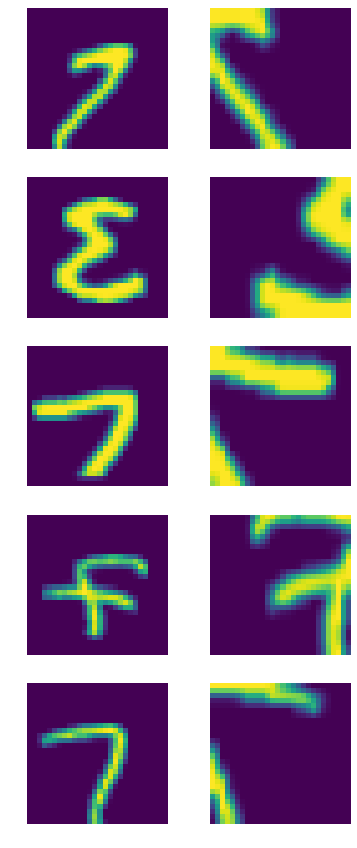

In [ ]:
b = dls.one_batch()
learn._split(b)
learn('before_fit')
learn('before_batch')
learn.byol.show(n=5)

In [ ]:
learn.fit(1)

In [ ]:
learn.recorder.losses

[tensor(3.8577)]

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00-utils.ipynb.
Converted 01-augmentations.ipynb.
Converted 02-layers.ipynb.
Converted 10-simclr.ipynb.
Converted 10b-simclr_v2.ipynb.
Converted 20-byol.ipynb.
Converted 30-swav.ipynb.
Converted index.ipynb.
